# DMQC Report: WMO 4900870

## Current status and metadata: 

- Inactive APEX float in Northern Pacific, quite close to southern Alaskan coastline for much of its life
- Completed 134 cycles over 3.5 years
- Currently in 'A' mode, adjusted by Henry Bittig using in-air data

In [1]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.dates import datestr2num
import matplotlib.pyplot as plt

from netCDF4 import Dataset

from pathlib import Path
import numpy as np
import pandas as pd
import bgcArgoDMQC as bgc

wmo = 4900870 # insert WMO number here
fig_path = Path('../../../figures/') / f'{wmo}' # where to save figures
fig_path.mkdir(exist_ok=True)
bgc.io.get_argo(wmo, local_path=bgc.io.Path.ARGO_PATH) # download the data to ensure you have up to date files
flt = bgc.sprof(wmo)
flt.clean()
gains = flt.calc_gains(ref='WOA') # calculate gain, can change to ref='NCEP' if in-air data is available
print(np.nanmean(gains))

\Users\GordonC\Documents\data\Argo\dac\meds\4900870\4900870_Rtraj.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900870\4900870_Sprof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900870\4900870_meta.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900870\4900870_prof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900870\4900870_tech.nc
Extracting WOA data for Jan
Extracting WOA data for Feb
Extracting WOA data for Mar
Extracting WOA data for Apr
Extracting WOA data for May
Extracting WOA data for Jun
Extracting WOA data for Jul
Extracting WOA data for Aug
Extracting WOA data for Sep
Extracting WOA data for Oct
Extracting WOA data for Nov
Extracting WOA data for Dec
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data -

## DOXY Audit Status

- No profiles flagged by DOXY audit

## Current data mode

- Data is in 'A' mode, done by Henry Bittig
- In air T-dependent gain agrees with WOA gain, will leave gain and just visually inspect data

In [2]:
nc = Dataset(flt.__Sprof__)
print(bgc.io.read_ncstr(nc['SCIENTIFIC_CALIB_COMMENT'][:][-1,1,-1,:].data))
nc.close()

by Henry Bittig; ORCID 0000-0002-8621-3095; after Bittig et al. (2018) eq. 23 T-dependent slope on PPOX_DOXY with linear time trend in slope; Using in-air obs; No time response correction done; error gives 1 sigma


## Visual QC

- Visualize the float and reference surface saturations, as well as the profiles. 
- Observe if DOXY data is set to '3' as it should be or if it is '1' or '2'. 
- Try to note cycles or other identifying features of potentially problematic profiles.

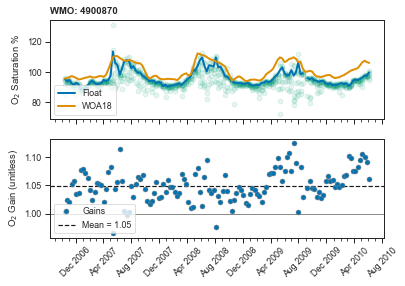

In [3]:
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_initial.png', bbox_inches='tight', dpi=250)

Figure 1: Top panel: Float oxygen percent saturation (blue line) compared to WOA percent saturation (orange line), with DOXY audit flagged cycle percent saturation (green stars, if applicable) and raw float percent saturation (orange circles). Bottom panel: calculated gains (blue dots) and flagged gains from DOXY audit (orange stars).

Notes: No outliers and magnitude roughly agrees with Henry's analysis

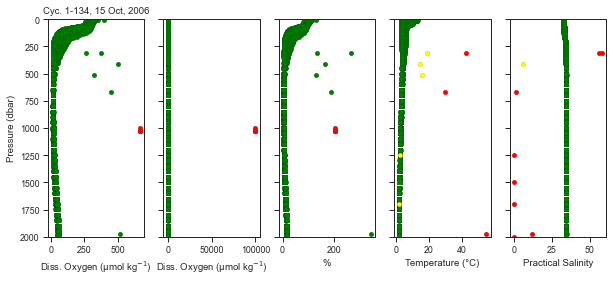

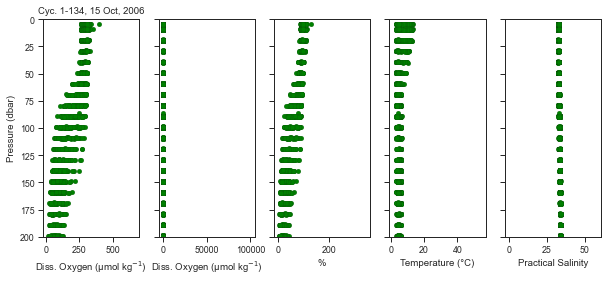

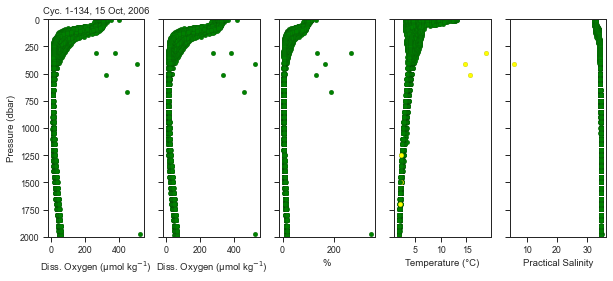

In [4]:
flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.fig.savefig(fig_path / 'qcprofiles.png', bbox_inches='tight', dpi=250)
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((200,0))
g.fig.savefig(fig_path / 'qcprofiles_shallow.png', bbox_inches='tight', dpi=250)
flt.clean()
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.fig.savefig(fig_path / 'qcprofiles_clean.png', bbox_inches='tight', dpi=250)
flt.reset()

Figures 2,3: Profiles coloured by QC flag (1-2, green, 3, yellow, 4, red) on difference depth scales.

Notes: Outlying points are cycle 106, will flag as bad

## Flag bad data, recalculate gain

- Using the plots above (and likely some more specific plots, made on a case-by-case basis), flag bad DOXY data as 4. 
- After flagging bad data, re-clean the data and re-calculate the gains.


Calculating gains using WOA surface data and float O2 percent saturation...
1.0494507419707104


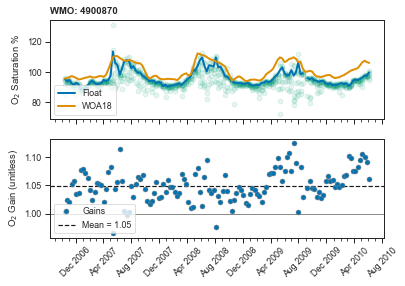

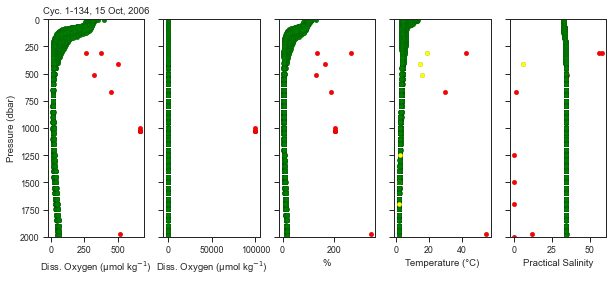

In [5]:
bad_oxygen = flt.df.CYCLE == 106 # index defining where the oxygen should be flagged as bad
flt.update_field('DOXY_QC', 4, where=bad_oxygen)
flt.update_field('DOXY_ADJUSTED_QC', 4, where=bad_oxygen)
flt.clean()
new_gains = flt.calc_gains(ref='WOA')
print(np.nanmean(new_gains))

g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_final.png', bbox_inches='tight', dpi=250)

flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.fig.savefig(fig_path / 'qcprofiles_output.png', bbox_inches='tight', dpi=250)

Figure x: Repeated gain plot with bad data removed.

## Update Fields and Export

- DOXY should be 3 by default, but many old floats have 1 or 0. Though it will be redundant in some cases, make sure DOXY_QC is not good.
- Apply the gain to calculate DOXY_ADJUSTED. 
- Fill in DOXY_ADJUSTED_ERROR with an appropriate fixed value.
- Fill in DOXY_ADJUSTED_QC. 
- Make sure DOXY_ADJUSTED and DOXY_ADJUSTED_ERROR are `FillValue` wherever DOXY_ADJUSTED_QC is bad.
- Export the D-mode files. During export, HISTORY parameters will be filled as well as SCIENTIFIC_CALIB parameters using some default structures and user info set by calling `bgc.configure.configure()`.

Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_001.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_002.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_003.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_004.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_005.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_006.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_007.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_008.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_009.nc...done
Working on

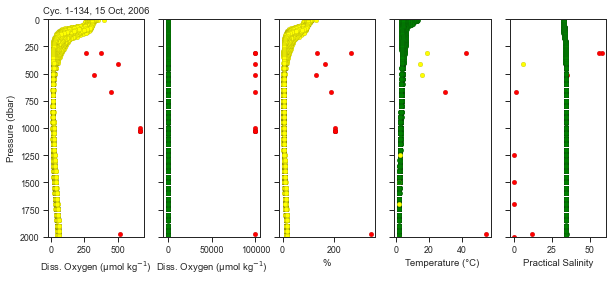

In [6]:
# make sure DOXY_QC is 3 instead of 0,1,2
flt.update_field('DOXY_QC', 3, where=flt.DOXY_QC.isin([0, 1, 2]))
# fill in DOXY_ADJUSTED_QC appropriately
# flt.update_field('DOXY_ADJUSTED_QC', flt.DOXY_QC)
# flt.update_field('DOXY_ADJUSTED_QC', 1, where=flt.DOXY_ADJUSTED_QC.isin([0, 3]))
# flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.TEMP_ADJUSTED_QC == 4)
# flt.update_field('DOXY_ADJUSTED_QC', 3, where=flt.PSAL_ADJUSTED_QC == 4)
# make sure the data is FillValues where adjusted values are still bad
flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.DOXY_ADJUSTED.isna())
flt.set_fillvalue('DOXY_ADJUSTED', where=flt.DOXY_ADJUSTED_QC == 4)
flt.set_fillvalue('DOXY_ADJUSTED_ERROR', where=flt.DOXY_ADJUSTED_QC == 4)

flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'DOXY_ADJUSTED', 'O2Sat', 'TEMP', 'PSAL'])
g.fig.savefig(fig_path / 'qcprofiles_final.png', bbox_inches='tight', dpi=250)

comment = 'by Henry Bittig; ORCID 0000-0002-8621-3095; after Bittig et al. (2018) eq. 23 T-dependent slope on PPOX_DOXY with linear time trend in slope; Using in-air obs; No time response correction done; error gives 1 sigma'
comment += f"; Visual QC by Christopher Gordon (DFO, ORCID {bgc.config['orcid']})"
comment = comment.replace('No time response correction done;', '')
flt.export_files(data_mode='D', comment=comment, coeff='previous', equation='previous')

In [7]:
# export the files
flt.export_files(data_mode='D')

Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_001.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_002.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_003.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_004.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_005.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_006.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_007.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_008.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/BD4900870_009.nc...done
Working on

In [12]:
import copy

loc = Path('/Users/GordonC/Documents/data/Argo/dac/meds/D/4900870/profiles/')
files = pd.read_csv(Path('../../../checker/summary/4900870/files.txt'))
varname = 'DOXY'
for fn in files.files:
    print(fn)
    nc = Dataset(loc / fn, 'r+')
    print(nc['DOXY'][:])
    flags = copy.deepcopy(nc[varname+'_QC'][:])
    flags[nc[varname][:].mask] = b'9'
    nc[varname+'_QC'][:] = flags
    if varname == 'DOXY':
        flags = copy.deepcopy(nc[varname+'_ADJUSTED_QC'][:])
        flags[nc[varname][:].mask] = b'9'
        nc[varname+'_ADJUSTED_QC'][:] = flags
    profile = copy.deepcopy(nc['PROFILE_DOXY_QC'][:])
    profile[0] = b'A'
    nc['PROFILE_DOXY_QC'][:] = profile
    nc.close()

BD4900870_038.nc
[[266.8898010253906 266.22174072265625 265.5940856933594
  265.5276184082031 265.9612121582031 267.0404357910156 275.7449035644531
  261.6912536621094 245.20611572265625 217.571533203125 174.8222198486328
  128.3998260498047 109.5694351196289 94.14728546142578 79.91806030273438
  69.87005615234375 63.352352142333984 58.76026916503906 53.5439453125
  47.11728286743164 43.69575881958008 40.38585662841797 37.43031692504883
  33.8582763671875 30.37080955505371 26.356327056884766
  22.419191360473633 20.93767547607422 19.248538970947266
  17.657503128051758 16.491283416748047 15.791306495666504
  15.141095161437988 14.678485870361328 14.633331298828125
  14.430139541625977 14.424696922302246 14.50416088104248
  13.966382026672363 12.682785034179688 10.9852294921875
  10.613211631774902 12.497206687927246 12.207223892211914
  10.970539093017578 11.200343132019043 11.501116752624512
  11.479531288146973 11.832491874694824 12.29826831817627 --]]
BD4900870_056.nc
[[309.90319824

In [11]:
nc.close()